# Simulating QA with Exact Diagonalization 

In [1]:
import tensorflow as tf
import tensorflow.linalg as tfl
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

physical_devices = tf.config.list_physical_devices('GPU')
print('GPU devices:', physical_devices)

if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

2023-03-17 10:27:19.006349: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 10:27:21.702584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/media/alberto/Volume/Kubuntu/miniconda3/envs/tf2/lib/
2023-03-17 10:27:21.703140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/media/alberto/Volume/Kubuntu/miniconda3/envs/tf2/lib/
2023-03-17 10:27:2

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-17 10:27:25.307102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 10:27:25.361825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 10:27:25.362159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Defining operators and init

In [2]:
sigma_x = tfl.LinearOperatorFullMatrix([[0., 1.], [1., 0.]])
sigma_z = tfl.LinearOperatorFullMatrix([[1., 0.], [0., -1.]])
id      = tfl.LinearOperatorIdentity(2)

def H_perc(data, labels):
    n_data, n = data.shape

    # define a batch of ientities operators where batch is the #data
    id_batch = tfl.LinearOperatorIdentity(2, batch_shape=[n_data])

    # define a batch of sigma_z operators where batch is the #data
    sigma_z_batch = tf.tile(tf.expand_dims(tf.constant([[1., 0.], [0., -1.]]), axis=0), [n_data, 1, 1])
    sigma_z_op = tfl.LinearOperatorFullMatrix(sigma_z_batch)

    # define a batch of data operators where batch is the #data.
    # each coordinate of a single datum is casted into a 2x2 operator,
    # which will be composed with the corresponding sigma_z operator
    # result is a list of n [n_data, 2, 2] opearators
    data_ops = [tfl.LinearOperatorDiag(tf.repeat(data, [2], axis=1)[:,i:i+2]) for i in range(0, n*2, 2)]

    ops = [tfl.LinearOperatorKronecker([id_batch]*i+[tfl.LinearOperatorComposition([data_ops[i], sigma_z_op])]+[id_batch]*(n-i-1)).to_dense() for i in range(n)]
    
    # opearotrs are first stacked on the n dimension and reduced, then labels are applied,
    # then heaviside step function is applied (relu), and finally reduced over n_data
    return tf.reduce_sum(tf.nn.relu(-tf.reshape(labels, (-1, 1, 1))*tf.reduce_sum(tf.stack(ops), axis=0)), axis=0) / tf.sqrt(n+0.)

# reimplementation of the previous function with an eye over ram usage
def H_perc_nobatch(data, labels):
    n_data, n = data.shape

    h_perc = tf.zeros((2**n, 2**n), dtype='float32')
    
    for i in tqdm(range(n_data), desc='Constructing H_perc'):

        op = tf.zeros((2**n, 2**n), dtype='float32')
        for j in range(n):

            data_op = tfl.LinearOperatorDiag(tf.repeat(data[i, :], [2], axis=0)[2*j:2*(j+1)])
            op     += tfl.LinearOperatorKronecker([id]*j+[tfl.LinearOperatorComposition([data_op, sigma_z])]+[id]*(n-j-1)).to_dense()
            del data_op

        h_perc += tf.nn.relu(-labels[i]*op)
        del op

    return h_perc / tf.sqrt(n+0.)

def H_x(n):
    sigma_xs = [tfl.LinearOperatorKronecker([id]*i+[sigma_x]+[id]*(n-i-1)).to_dense() for i in range(n)]
    return -tf.reduce_sum(tf.stack(sigma_xs), axis=0)

def H_z(n):
    sigma_zs = [tfl.LinearOperatorKronecker([id]*i+[sigma_z]+[id]*(n-i-1)).to_dense() for i in range(n)]
    return tf.reduce_sum(tf.stack(sigma_zs), axis=0)

def H_QA(p, P, Hz, Hx):
    frac = p/P
    return tf.cast(frac*Hz + (1-frac)*Hx, dtype='complex128')


def init_state(n):
    return tf.ones((2**n,), dtype='complex128')/tf.sqrt((2.**n+0.j))

2023-03-17 10:27:25.412136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 10:27:25.414180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 10:27:25.414522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 10:27:25.414800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

### Tests

In [63]:
data   = tf.constant([[1., 1.], [-1., 1.]])
labels = tf.constant([1., -1.])

h_perc = H_perc(data, labels)
h_perc

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 1.4142135, 0.       ],
       [0.       , 0.       , 0.       , 1.4142135]], dtype=float32)>

In [74]:
H_perc_nobatch(data, labels)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 1.4142135, 0.       ],
       [0.       , 0.       , 0.       , 1.4142135]], dtype=float32)>

In [58]:
tfl.eigh(h_perc)

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([0.        , 0.        , 0.57735026, 0.57735026, 0.57735026,
        0.57735026, 2.309401  , 2.309401  ], dtype=float32)>,
 <tf.Tensor: shape=(8, 8), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>)

In [150]:
h_x = H_x(data.shape[1])
h_x

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.]], dtype=float32)>

In [15]:
datum_ops = [tfl.LinearOperatorDiag(tf.repeat(data[0,:], [2], axis=0)[i:i+2]) for i in range(0, 2*2, 2)]
datum_ops[1].to_dense()

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.,  0.],
       [ 0., -1.]], dtype=float32)>

In [26]:
init_state(2)

<tf.Tensor: shape=(4,), dtype=complex128, numpy=array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])>

In [253]:
h_t = H_QA(1, 1_000, h_perc, h_x)
h_t

<tf.Tensor: shape=(4, 4), dtype=complex128, numpy=
array([[0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j]])>

## Defining algorithm functions

In [3]:
def ed_qa_step(state, Ht, dt):

    eigvals, eigvecs = tfl.eigh(Ht)
    # define time evolution operator
    U = tf.exp(-1.j*eigvals*dt)

    # rewrite state in eigenvector basis, apply time evolution operator, project back to computational basis
    evolved = tfl.matvec(eigvecs, U * tfl.matvec(eigvecs, state, adjoint_a=True))
    return evolved

## Running ED QA

In [24]:
def create_dataset(N : int, features : int):
    """Create dataset as described by ref. paper, i.e. random +-1 values."""
    x = np.random.randint(2, size=(N, features))
    x[ x == 0 ] = -1  # data is encoded as +- 1
    return x

In [30]:
tau = 1_000
P   = 1_000
dt  = tau/P
N_data = 8
N_feat = 10

data   = create_dataset(N_data, N_feat).astype('float32')
labels = tf.ones((N_data), 'float32')

In [31]:
data = np.load('patterns8_10.npy')
#h_perc = tf.cast(H_perc_nobatch(data, labels), 'complex128')

In [32]:

h_perc = tf.cast(H_perc_nobatch(data, labels), 'complex128')
E0     = tfl.eigh(h_perc)[0][0]
h_x    = tf.cast(H_x(data.shape[1]), 'complex128')
#h_z    = tf.cast(H_z(data.shape[1]), 'complex128')

state = init_state(data.shape[1])
loss  = []

pbar = tqdm(range(P), desc='ED QA')
for i in pbar:

    h_t   = H_QA(i+1, P, h_perc, h_x)
    state = ed_qa_step(state, h_t, dt)

    loss.append(tf.cast((tf.tensordot(tf.math.conj(state), tfl.matvec(tf.cast(h_perc, 'complex128'), state), axes=1)-E0)/N_feat, 'float32').numpy())

    pbar.set_postfix({'loss':loss[-1], 'norm':tf.cast(tf.norm(state), 'float32').numpy()})

Constructing H_perc:   0%|          | 0/8 [00:00<?, ?it/s]

ED QA:   0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
state

<tf.Tensor: shape=(1024,), dtype=complex128, numpy=
array([ 3.12656941e-05-1.72558920e-05j, -1.13552917e-05-1.61864872e-05j,
        6.86375497e-06-1.67800761e-05j, ...,
        1.43318255e-04+8.19053867e-05j,  1.91462901e-05+4.63298154e-05j,
        5.05310567e-05+2.08742778e-05j])>

In [37]:
np.save('result', state.numpy())

### Tests

In [103]:
which_down = tf.where(tf.cast(tfl.eigh(h_perc)[1][0], 'float32') > 0.).numpy()
which_down

array([[142]])

In [106]:
state.numpy()[which_down[0]]

array([-8.16668636e-06+4.13087259e-05j])

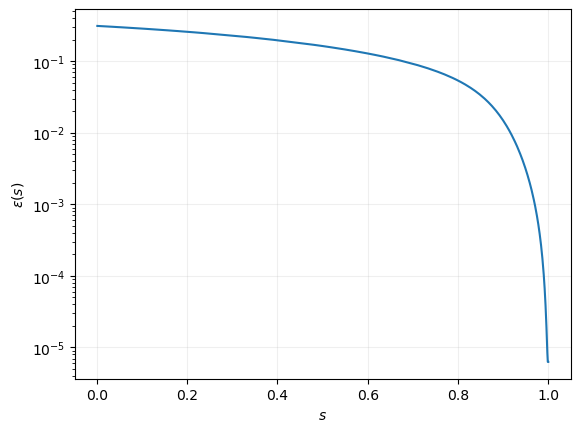

In [36]:
plt.plot((np.array(range(P))+1)/P, abs(np.asarray(loss)))
plt.yscale('log')
plt.ylabel(r'$\epsilon(s)$')
plt.xlabel(r'$s$')
plt.grid(alpha=0.2)

In [42]:
# comparison with dQA approach

psi_dqa = np.load('stato2.npy')
psi_qa  = np.load('result.npy')


tf.cast(tf.norm(tfl.matvec(tf.cast(psi_dqa, 'complex128'), psi_qa, adjoint_a=True )), 'float32')

<tf.Tensor: shape=(), dtype=float32, numpy=0.9799511>

## Study the time evolution operator
To efficiently simulate the dynamics I want that the eigenvalues do not change very fast from one step to the next one

In [11]:
tau = 100
P   = 1_000
dt  = tau/P
N_data = 8
N_feat = 10

#data   = create_dataset(N_data, N_feat).astype('float32')
labels = tf.ones((N_data), 'float32')

h_perc = tf.cast(H_perc_nobatch(data, labels), 'complex128')
E0     = tfl.eigh(h_perc)[0][0]
h_x    = tf.cast(H_x(data.shape[1]), 'complex128')

Constructing H_perc:   0%|          | 0/8 [00:00<?, ?it/s]

2023-03-17 10:32:39.160746: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5601b5f56d80


In [49]:
eigvals_array = np.empty((P, 2**N_feat))

pbar = tqdm(range(P), desc='Spectral analysis')
for i in pbar:
    
    h_t   = H_QA(i+1, P, h_perc, h_x)
    eigvals, eigvecs = tfl.eigh(h_t)

    eigvals_array[i] = tf.cast(eigvals, 'float32')

Spectral analysis:   0%|          | 0/1000 [00:00<?, ?it/s]

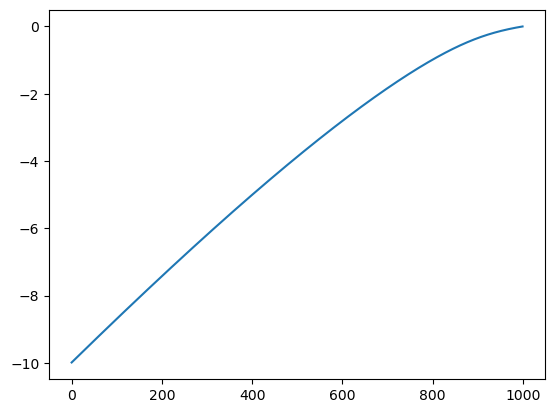

In [50]:
plt.plot(range(P), eigvals_array[:,0])

In [16]:
state = tf.cast(psi_dqa.squeeze(), 'complex128')
epsilon = (tf.cast(tf.tensordot(tf.math.conj(state), tfl.matvec(h_perc, state), axes=1), 'float32').numpy()-E0)/N_data
epsilon

<tf.Tensor: shape=(), dtype=complex128, numpy=(0.005543623585253954+0j)>

In [13]:
state

<tf.Tensor: shape=(1024, 1), dtype=complex128, numpy=
array([[ 4.01072640e-07-6.31496687e-06j],
       [ 3.94224998e-07+1.55372236e-05j],
       [ 6.62732873e-06-5.25240330e-06j],
       ...,
       [-9.93800768e-07-4.13709472e-07j],
       [-1.63134530e-07-2.94461330e-07j],
       [ 2.34337222e-06+5.77729043e-06j]])>

## Deprecated stuff

In [3]:
def H_perc2(state, data, labels):
    n_data, n = data.shape
    h_perc = tf.zeros((2**n, 2**n), dtype='complex128')
    
    id      = tfl.LinearOperatorIdentity(2) 
    sigma_z = tfl.LinearOperatorFullMatrix(tf.constant([[1., 0.], [0., -1.]]))

    for i in range(n_data):
        datum_ops = [tfl.LinearOperatorDiag(tf.repeat(data[i,:], [2], axis=0)[j:j+2]) for j in range(0, n*2, 2)]
        ops = [tfl.LinearOperatorKronecker([id]*i+[tfl.LinearOperatorComposition([sigma_z, datum_ops[i]])]+[id]*(n-i-1)).to_dense() for j in range(n)]
        result_op = tf.cast(-tf.reshape(labels[i], (1, 1))*tf.reduce_sum(tf.stack(ops), axis=0), 'complex128')
        if tf.cast(tf.tensordot(tf.math.conj(state), tfl.matvec(result_op, state), axes=1), 'float32') < 0.:
            continue
        else:
            h_perc = h_perc + result_op

    return h_perc